<a href="https://colab.research.google.com/github/morcellinus/Introduction_to_Deep_Learning/blob/main/group7_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Important Module Explanation**
---

## <mark>1. Attention module to predict Publisher & User Credibility</mark> </br>
---

</br>

## $ Z_h = Attention(Q, K, V)  = softmax\Big(\frac{QW_hK^T}{\sqrt{d}} \odot(D^p)^\frac{-1}{2}A^{pn}(D^n)^\frac{-1}{2}\Big)V$
</br>

* #### `linear1 = torch.einsum("bd,dd,sd->bs", X_user, Wcm, M) / self.scale` : inner product of matrices Q, W, and K  ($\frac{QW_hK^T}{\sqrt{d}} $). </br>
* #### `A_us = self.A_us[X_user_id.cpu(), :].todense()`: node adjacency matrix in the equation ($A^{pn}$).

</br>

#### For our paper, Q is publisher embeddings, K and V are news embeddings
</br>

```python
     def retweet_user_multi_head(self, X_ruser, X_ruser_id, Wam):
        # News embeddings as well for Key (4.2_equation(6))
        M = self.user_embedding.weight

        # Linear inner product inside Attention(R, U, U)
        linear1 = torch.einsum("bnd,dd,md->bnm", X_ruser, Wam, M) / self.scale # m x bsz
        # X_ruser = Query, Wam = W, M = Key
        linear1 = self.relu(linear1)

        s1, s2 = X_ruser_id.size()

        idx = X_ruser_id.view(-1).cpu()

        # A_uu: Adjecency matrix (A_uu in 4.2_equation(6))
        A_uu = self.A_uu[idx, :].todense()
        A_uu = torch.FloatTensor(A_uu).view(s1, s2, -1).cuda()
        # Attention(R_j, U, U), and get Z_h
        alpha = F.softmax(linear1 * A_uu, dim=-1) 
        alpha = self.dropout(alpha)
        return alpha.matmul(M)
```

</br>

```python
def retweet_user_multi_head(self, X_ruser, X_ruser_id, Wam):
        # News embeddings as well for Key (4.2_equation(6))
        M = self.user_embedding.weight

        # Linear inner product inside Attention(R, U, U)
        linear1 = torch.einsum("bnd,dd,md->bnm", X_ruser, Wam, M) / self.scale # m x bsz
        # X_ruser = Query, Wam = W, M = Key
        linear1 = self.relu(linear1)

        s1, s2 = X_ruser_id.size()

        idx = X_ruser_id.view(-1).cpu()

        # A_uu: Adjecency matrix (A_uu in 4.2_equation(6))
        A_uu = self.A_uu[idx, :].todense()
        A_uu = torch.FloatTensor(A_uu).view(s1, s2, -1).cuda()
        # Attention(R_j, U, U), and get Z_h
        alpha = F.softmax(linear1 * A_uu, dim=-1) 
        alpha = self.dropout(alpha)
        return alpha.matmul(M)
```

## <mark>2. Publisher & User Representation Encoder</mark> </br>
---
### **Publisher Representation**
## $ \tilde{P} = ELU([Z_1;Z_2; ...;Z_H]W_o) + P $
</br>

### **User Representation**
## $\tilde{R_j} = ELU([Z_1;Z_2;...;Z_H]W_o) + R_j$

</br>

#### Here, $Z_i$'s are the results from Attention module above.</br>
#### Then these results go through $ELU$ activation function, then added with Publisher(user) embeddings

* #### `m_hat = torch.cat(m_hat, dim=-1).matmul(self.W1)` : Concat $Z_i$'s </br> 
* #### `m_hat = self.elu(m_hat)`: $ELU$ activation function </br> 
* #### `U_hat = m_hat + X_user`: Add Publisher(User) embedding
</br>

```python
    # Publisher Representation Encoder from Publisher Attention result Z_h
    def publisher_encoder(self, X_user, X_user_id):
        m_hat = []
        # Get Z_h from Attention
        for i in range(self.n_heads):
            m_hat.append(self.user_multi_head(X_user, X_user_id, self.Wcm[i]))

        # Concat Z1 to ZJ
        m_hat = torch.cat(m_hat, dim=-1).matmul(self.W1)
        # ELU activation function
        m_hat = self.elu(m_hat)
        m_hat = self.dropout(m_hat)
        #U_hat = publisher's representation
        U_hat = m_hat + X_user  
        return U_hat

    # User Representation Encoder from User Attention result Z_h
    def retweet_user_encoder(self, X_ruser, X_ruser_id): 
        '''
        :param X_ruser:  (bsz, num_users, d)
        :param X_ruser_id: (bsz, num_users)
        :return:
        '''
        m_hat = []
        # Get Z_h from Attention
        for i in range(self.n_heads):
            m_hat.append(self.retweet_user_multi_head(X_ruser, X_ruser_id, self.Wam[i]))

        # Concat Z_1j to Z_Hj
        m_hat = torch.cat(m_hat, dim=-1).matmul(self.W2)
        # ELU activation function
        m_hat = self.elu(m_hat)
        m_hat = self.dropout(m_hat)

        # a_hat = retweet users' representation
        a_hat = m_hat + X_ruser  # bsz x 20 x d
        return a_hat
```

## <mark>3. Publisher & User Representation Fusion</mark> </br>
---

### **Source representation (Fusion between Publisher and User representation)**

</br>

## $\tilde{m_j} = [\tilde{P};R';\tilde{P} \odot R';\tilde{P}-R']W_F + b_F$ <br>
where $R' = \sum_{k=1}^{K}{a_k\tilde{{R_i}^T}}$

</br>

#### This finds the differences between fake and true news from the graph-based publisher & User credibility


* #### `retweet_rep = torch.einsum("bn,bnd->bd", alpha, r_user_rep)` :  Get  $R'$</br> 

* 
```python
def source_encoder(self, X_source, r_user_rep, user_rep): 

        # Combine many user representation to one news into one user representation to one news, which is R'
        # linear1 = R_k_tilda
        linear1 = torch.einsum("bd,bnd->bn", X_source, r_user_rep) # / self.scale
        alpha = F.softmax(linear1, dim=-1)
        # retweet_rep = R'
        retweet_rep = torch.einsum("bn,bnd->bd", alpha, r_user_rep)

        # get the combined representation (Fusion)
        source_rep = torch.cat([retweet_rep, user_rep,
                                retweet_rep * user_rep,
                                retweet_rep - user_rep], dim=-1)  # .mm(self.W) #
        source_rep = self.linear(source_rep)
        source_rep = self.dropout(source_rep)
        return source_rep
```
#### : Get $\tilde{m_j}$

## <mark>4. Combined Loss Function to Optimize Each Process</mark> </br>
---
</br>

#### There exist three different losses in this paper since there are three things to predict 

</br>

**1) Publisher Credibility Class (reliable, uncretain, unreliable)** </br>
**2) User Credibility Class (as same as Publisher)**</br>
**3) News class (NR, FR, UR, TR)**

</br>

#### They are combined together to optimize the credibility prediction and fake news detection

</br>

## $\mathcal{L}\big(c|\mathcal{G}(V_p, E), \mathcal{G}(V_u, E), \mathcal{N};\theta\big) = \mathcal{L_p} + \mathcal{L_u} + \mathcal{L_n}$
</br>

#### $\mathcal{L_p}$: Cross Entropy Loss for Publisher Credibility 
#### $\mathcal{L_u}$: Cross Entropy Loss for User Credibility
#### $\mathcal{L_n}$: Cross Entropy Loss for Fake News Detection

</br>

* #### `loss = loss1 + pub_loss + uloss`: Combining loss functions

</br>

```python
# News Class Prediction, Publisher & Retweet User Credibilities Prediction
                logit, ulogit, rulogit = self.forward(X_source_wid, X_source_id, X_user_id, X_ruid)

                # loss for fake news detection
                loss1 = loss_func(logit, batch_y)

                # loss for publisher's credibility prediction
                pub_loss = loss_func(ulogit, batch_y_cred)

                # loss for user's credibility prediction
                uloss = loss_func2(rulogit.view(-1, rulogit.size(-1)), batch_y_rucred.view(-1))

                # Loss sum
                loss = loss1 + pub_loss + uloss
```

# 2. **Entire Model Definition**
---

In [ ]:
!git clone https://github.com/chunyuanY/FakeNewsDetection

%cd FakeNewsDetection

Cloning into 'FakeNewsDetection'...
remote: Enumerating objects: 73, done.
remote: Total 73 (delta 0), reused 0 (delta 0), pack-reused 73
Unpacking objects: 100% (73/73), done.
Checking out files: 100% (59/59), done.
/content/FakeNewsDetection



## 2-1. Neural Network class Definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils as utils
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.best_acc = 0
        self.patience = 0

        # Gradient Clipping condition set
        self.init_clip_max_norm = 5.0
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    def forward(self):
        raise NotImplementedError

    # Fitting the Model
    def fit(self, X_train_source_wid, X_train_source_id, X_train_user_id, X_train_ruid, y_train, y_train_cred, y_train_rucred,
            X_dev_source_wid, X_dev_source_id, X_dev_user_id, X_dev_ruid, y_dev):
      
      # X_train_source_wid : Source Representation word ID
      # X_train_source_id : Source Representation ID
      # X_train_user_id : Publisher Representation ID
      # X_train_ruid : User Representation ID
      # y_train : News Class
      # y_train_cred: Publisher Credibility Class
      # y_train_rucred: User Credibility Class

        if torch.cuda.is_available():
            self.cuda()

        # batch size
        batch_size = self.config['batch_size']

        # User Adam optimizer as the optimizer, and use learning rate and weight_decay to prevent overfitting
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.config['lr'], weight_decay=self.config['reg'], amsgrad=True)  # self.optimizer = torch.optim.Adadelta(self.parameters(), weight_decay=self.config['reg'])

        # Tensorize ID Embeddings
        X_train_source_wid = torch.LongTensor(X_train_source_wid)
        X_train_source_id = torch.LongTensor(X_train_source_id)
        X_train_user_id = torch.LongTensor(X_train_user_id)
        X_train_ruid = torch.LongTensor(X_train_ruid)

        y_train = torch.LongTensor(y_train)
        y_train_cred = torch.LongTensor(y_train_cred)
        y_train_rucred = torch.LongTensor(y_train_rucred)

        dataset = TensorDataset(X_train_source_wid, X_train_source_id, X_train_user_id, X_train_ruid, y_train, y_train_cred, y_train_rucred)

        # dataloader to split the data into batch size
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Cross Entropy Loss for Fake News Detection and Publisher Credibility Scores Prediction
        loss_func = nn.CrossEntropyLoss()

        # Cross Entropy Loss for User Credibility Scores Prediction
        loss_func2 = nn.CrossEntropyLoss(ignore_index=3)

        ###############
        # Let's Train #
        ###############

        for epoch in range(1, self.config['epochs']+1):
            print("\nEpoch ", epoch, "/", self.config['epochs'])
            self.train()
            avg_loss = 0
            avg_acc = 0
            for i, data in enumerate(dataloader):
                with torch.no_grad():
                    X_source_wid, X_source_id, X_user_id, X_ruid, batch_y, batch_y_cred, batch_y_rucred = (item.cuda(device=self.device) for item in data)

                self.optimizer.zero_grad()
                # News Class Prediction, Publisher & Retweet User Credibilities Prediction
                logit, ulogit, rulogit = self.forward(X_source_wid, X_source_id, X_user_id, X_ruid)

                # loss for fake news detection
                loss1 = loss_func(logit, batch_y)

                # loss for publisher's credibility prediction
                pub_loss = loss_func(ulogit, batch_y_cred)

                # loss for user's credibility prediction
                uloss = loss_func2(rulogit.view(-1, rulogit.size(-1)), batch_y_rucred.view(-1))

                # Loss sum
                loss = loss1 + pub_loss + uloss

                loss.backward()
                self.optimizer.step()

                # Calculating accuracy
                corrects = (torch.max(logit, 1)[1].view(batch_y.size()).data == batch_y.data).sum()
                accuracy = 100*corrects/len(batch_y)
                print('Batch[{}] - loss: {:.6f}  acc: {:.4f}%({}/{})'.format(i, loss.item(), accuracy, corrects, batch_y.size(0)))

                avg_loss += loss.item()
                avg_acc += accuracy

                # Gradient Clipping
                if self.init_clip_max_norm is not None:
                    utils.clip_grad_norm_(self.parameters(), max_norm=self.init_clip_max_norm)

            # Print out average loss and accuracy after each epochs
            cnt = y_train.size(0) // batch_size + 1
            print("Average loss:{:.6f} average acc:{:.6f}%".format(avg_loss/cnt, avg_acc/cnt))

            # If the epoch is half way done but still the model updates do not occur, redesign learning rate
            if epoch > self.config['epochs']//2 and self.patience > 2: #
                print("Reload the best model...")
                self.load_state_dict(torch.load(self.config['save_path']))
                now_lr = self.adjust_learning_rate(self.optimizer)
                print(now_lr)
                self.patience = 0
            
            # Evaluating validation set
            self.evaluate(X_dev_source_wid, X_dev_source_id, X_dev_user_id, X_dev_ruid, y_dev, epoch)
     

    # Function needed to adjust learning rate
    def adjust_learning_rate(self, optimizer, decay_rate=.5):
        now_lr = 0
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * decay_rate
            now_lr = param_group['lr']
        return now_lr


    # Function needed to evaluate validation set
    def evaluate(self, X_dev_source_wid, X_dev_source_id, X_dev_user_id, X_dev_ruid, y_dev, epoch):
        y_pred = self.predict(X_dev_source_wid, X_dev_source_id, X_dev_user_id, X_dev_ruid)
        acc = accuracy_score(y_dev, y_pred)
        print("Val set acc:", acc)
        print("Best val set acc:", self.best_acc)

        # save the model when the performance gets better & reset patience
        if epoch >= self.config['epochs']//2 and acc > self.best_acc:  #
            self.best_acc = acc
            self.patience = 0
            torch.save(self.state_dict(), self.config['save_path'])
            print(classification_report(y_dev, y_pred, target_names=self.config['target_names'], digits=5))
            print("save model!!!")
        
        
        else:
            self.patience += 1


    # Function to evaluate test dataset
    def predict(self, X_dev_source_wid, X_dev_source_id, X_dev_user_id, X_dev_ruid):
        if torch.cuda.is_available():
            self.cuda()

        self.eval()
        y_pred = []

        # Tensorize ID embeddings
        X_dev_source_wid = torch.LongTensor(X_dev_source_wid)
        X_dev_source_id = torch.LongTensor(X_dev_source_id)
        X_dev_user_id = torch.LongTensor(X_dev_user_id)
        X_dev_ruid = torch.LongTensor(X_dev_ruid)

        # Set Dataset
        dataset = TensorDataset(X_dev_source_wid, X_dev_source_id, X_dev_user_id, X_dev_ruid)
        dataloader = DataLoader(dataset, batch_size=32)

        for i, data in enumerate(dataloader):
            with torch.no_grad():
                X_source_wid, X_source_id, X_user_id, \
                X_ruid = (item.cuda(device=self.device) for item in data)

            logits, _, _ = self.forward(X_source_wid, X_source_id, X_user_id, X_ruid)
            predicted = torch.max(logits, dim=1)[1]
            y_pred += predicted.data.cpu().numpy().tolist()
        return y_pred

## 2-2. Structure-aware Multi-head Attention Network (SMAN)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from model.NeuralNetwork import NeuralNetwork

class PGAN(NeuralNetwork):

    def __init__(self, config):
        super(PGAN, self).__init__()
        self.config = config
        embedding_weights = config['embedding_weights']
        V, D = embedding_weights.shape
        self.n_heads = config['n_heads']

        # source adjacency matrix(publisher i and news j), User adjecency matrix(user i and publisher j)
        self.A_us = config['A_us']
        self.A_uu = config['A_uu']
        embeding_size = config['embeding_size']

        # Word Embedding, Publisher Embedding, and Source Embedding(Combined embedding between publisher & User representation)
        self.word_embedding = nn.Embedding(V, D, padding_idx=0, _weight=torch.from_numpy(embedding_weights))
        self.user_embedding = nn.Embedding(config['A_us'].shape[0], embeding_size, padding_idx=0)
        self.source_embedding = nn.Embedding(config['A_us'].shape[1], embeding_size)

        # Convolution and pooling
        self.convs = nn.ModuleList([nn.Conv1d(300, 100, kernel_size=K) for K in config['kernel_sizes']])
        self.max_poolings = nn.ModuleList([nn.MaxPool1d(kernel_size=config['maxlen'] - K + 1) for K in config['kernel_sizes']])

        # Transformation matrix used in attention inner product for publisher (4.1_equation (1))
        self.Wcm = [nn.Parameter(torch.FloatTensor(embeding_size, embeding_size)).cuda() for _ in
                    range(self.n_heads)]
        
        # Transformation matrix used in attention ineer product for user (4.2_equation(6))
        self.Wam = [nn.Parameter(torch.FloatTensor(embeding_size, embeding_size)).cuda() for _ in
                    range(self.n_heads)]

        # Diagonal matrices applied to normalize the adjacency matrix A_us & A_uu 
        self.scale = torch.sqrt(torch.FloatTensor([embeding_size])).cuda() #  // self.n_heads

        # Linear transformation matrix for Publisher in ELU activation function (4.1_equation(3))
        self.W1 = nn.Parameter(torch.FloatTensor(embeding_size * self.n_heads, embeding_size))

        # Linear transformation matrix for User in ELU activation function (4.2)
        self.W2 = nn.Parameter(torch.FloatTensor(embeding_size * self.n_heads, embeding_size))
        self.linear = nn.Linear(400, 200)

        # Dropout
        self.dropout = nn.Dropout(config['dropout'])
        # Relu activation function
        self.relu = nn.ReLU()
        # ELU activation function
        self.elu = nn.ELU()

        # News class(Non-fake, Fake, Unverified, True) classification result
        self.fc_out = nn.Sequential(
            nn.Linear(300 + 2 * embeding_size, 100),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(100, config["num_classes"])
        )

        # Publisher credibility classification result
        self.fc_user_out = nn.Sequential(
            nn.Linear(embeding_size, 100),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(100, 3)
        )

        # User credibility classification result
        self.fc_ruser_out = nn.Sequential(
            nn.Linear(embeding_size, 100),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(100, 3)
        )
        print(self)
        self.init_weights()

    # Weight normalization
    # https://eda-ai-lab.tistory.com/404
    # Xavier normalizes weights according to the characteristic of each layers
    def init_weights(self):
        init.xavier_normal_(self.user_embedding.weight)
        init.xavier_normal_(self.source_embedding.weight)
        for i in range(self.n_heads):
            init.xavier_normal_(self.Wcm[i])
            init.xavier_normal_(self.Wam[i])

        init.xavier_normal_(self.W1)
        init.xavier_normal_(self.W2)
        init.xavier_normal_(self.linear.weight)
        for name, param in self.fc_out.named_parameters():
            if name.__contains__("weight"):
                init.xavier_normal_(param)
        for name, param in self.fc_user_out.named_parameters():
            if name.__contains__("weight"):
                init.xavier_normal_(param)
        for name, param in self.fc_ruser_out.named_parameters():
            if name.__contains__("weight"):
                init.xavier_normal_(param)

    # Multi-head attention module to get publisher's representation
    def user_multi_head(self, X_user, X_user_id, Wcm):
        # M = source_embedding's weight
        M = self.source_embedding.weight

        # matrix product inside the Attention(P, N, N) (4.1_equation(1))
        # X_user = Query, Wcm = W, M = Key
        linear1 = torch.einsum("bd,dd,sd->bs", X_user, Wcm, M) / self.scale
        
        linear1 = self.relu(linear1) # (batch, |S|)

        # Publisher Adjacency matrix (A_pn in 4.1_equation(1))
        A_us = self.A_us[X_user_id.cpu(), :].todense()
        A_us = torch.FloatTensor(A_us).cuda()   # (batch, |S|)

        # Attention(P, N, N), and get Z_h (4.1_equation(2))
        alpha = F.softmax(linear1 * A_us, dim=-1)
        alpha = self.dropout(alpha)
        return alpha.matmul(M)

    # Multi-head attention module to get user's representation
    def retweet_user_multi_head(self, X_ruser, X_ruser_id, Wam):
        # News embeddings as well for Key (4.2_equation(6))
        M = self.user_embedding.weight

        # Linear inner product inside Attention(R, U, U)
        linear1 = torch.einsum("bnd,dd,md->bnm", X_ruser, Wam, M) / self.scale # m x bsz
        # X_ruser = Query, Wam = W, M = Key
        linear1 = self.relu(linear1)

        s1, s2 = X_ruser_id.size()

        idx = X_ruser_id.view(-1).cpu()

        # A_uu: Adjecency matrix (A_uu in 4.2_equation(6))
        A_uu = self.A_uu[idx, :].todense()
        A_uu = torch.FloatTensor(A_uu).view(s1, s2, -1).cuda()
        # Attention(R_j, U, U), and get Z_h
        alpha = F.softmax(linear1 * A_uu, dim=-1) 
        alpha = self.dropout(alpha)
        return alpha.matmul(M)

    # Publisher Representation Encoder from Publisher Attention result Z_h
    def publisher_encoder(self, X_user, X_user_id):
        m_hat = []
        # Get Z_h from Attention
        for i in range(self.n_heads):
            m_hat.append(self.user_multi_head(X_user, X_user_id, self.Wcm[i]))

        # Concat Z1 to ZJ
        m_hat = torch.cat(m_hat, dim=-1).matmul(self.W1)
        # ELU activation function
        m_hat = self.elu(m_hat)
        m_hat = self.dropout(m_hat)
        #U_hat = publisher's representation
        U_hat = m_hat + X_user  
        return U_hat

    # User Representation Encoder from User Attention result Z_h
    def retweet_user_encoder(self, X_ruser, X_ruser_id): 
        '''
        :param X_ruser:  (bsz, num_users, d)
        :param X_ruser_id: (bsz, num_users)
        :return:
        '''
        m_hat = []
        # Get Z_h from Attention
        for i in range(self.n_heads):
            m_hat.append(self.retweet_user_multi_head(X_ruser, X_ruser_id, self.Wam[i]))

        # Concat Z_1j to Z_Hj
        m_hat = torch.cat(m_hat, dim=-1).matmul(self.W2)
        # ELU activation function
        m_hat = self.elu(m_hat)
        m_hat = self.dropout(m_hat)

        # a_hat = retweet users' representation
        a_hat = m_hat + X_ruser  # bsz x 20 x d
        return a_hat

    # Combine Publisher's Representation and User's Representatino to get Combined Representation called Source

    ###################################
    # This process is called "FUSION" #
    ###################################

    def source_encoder(self, X_source, r_user_rep, user_rep): 

        # Combine many user representation to one news into one user representation to one news, which is R'
        # linear1 = R_k_tilda
        linear1 = torch.einsum("bd,bnd->bn", X_source, r_user_rep) # / self.scale
        alpha = F.softmax(linear1, dim=-1)
        # retweet_rep = R'
        retweet_rep = torch.einsum("bn,bnd->bd", alpha, r_user_rep)

        # get the combined representation (Fusion)
        source_rep = torch.cat([retweet_rep, user_rep,
                                retweet_rep * user_rep,
                                retweet_rep - user_rep], dim=-1)  # .mm(self.W) #
        source_rep = self.linear(source_rep)
        source_rep = self.dropout(source_rep)
        return source_rep

    # Convolution layer to get news representation m_j
    def text_representation(self, X_word):
        # Get news content representation from CNN Module
        X_word = X_word.permute(0, 2, 1)
        conv_block = []
        for Conv, max_pooling in zip(self.convs, self.max_poolings):
            act = self.relu(Conv(X_word))
            pool = max_pooling(act).squeeze()
            conv_block.append(pool)

        features = torch.cat(conv_block, dim=1)
        features = self.dropout(features)
        return features

    # Let's get credibility scores
    def forward(self, X_source_wid, X_source_id, X_user_id, X_ruser_id):  # , X_composer_id, X_reviewer_id
        '''
        :param X_source_wid size: (batch_size, max_words)
                X_source_id size: (batch_size, )
                X_user_id  size: (batch_size, )
                X_retweet_id  size: (batch_size, max_retweets)
                X_retweet_uid  size: (batch_size, max_retweets)
        :return:
        '''
        X_word = self.word_embedding(X_source_wid)
        X_user = self.user_embedding(X_user_id)
        X_ruser = self.user_embedding(X_ruser_id)
        X_source = self.source_embedding(X_source_id)
        # News content representation
        X_text = self.text_representation(X_word)

        # Publisher representation
        user_rep = self.publisher_encoder(X_user, X_user_id)
        # User representation
        r_user_rep = self.retweet_user_encoder(X_ruser, X_ruser_id)  #
        # Fusion Representation
        source_rep = self.source_encoder(X_source, r_user_rep, user_rep)  #
        # News Representation + Source Representation to get news classification
        tweet_rep = torch.cat([X_text, source_rep], dim=-1)

        # Final representation
        Xt_logit = self.fc_out(tweet_rep)
        # Publisher representation
        Xu_logit = self.fc_user_out(user_rep)
        # Retweet User representation
        Xru_logit = self.fc_ruser_out(r_user_rep)

        return Xt_logit, Xu_logit, Xru_logit

# **3. Training the Model**
---

In [ ]:
import pandas as pd
import seaborn as sns
import os
import pickle
import torch
from sklearn.metrics import classification_report
from model.Mymodel import PGAN

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Get Preprocessed Embedding Data
def load_dataset(task):
    print("task: ", task)

    ##################################################################
    # Data and Matrix Weights are all given AFTER ALREADY PROCESSED #
    ##################################################################

    A_us, A_uu = pickle.load(open("dataset/"+task+"/relations.pkl", 'rb'))
    X_train_source_wid, X_train_source_id, X_train_user_id, X_train_ruid, y_train, y_train_cred, y_train_rucred, word_embeddings = pickle.load(open("dataset/"+task+"/train.pkl", 'rb'))
    X_dev_source_wid, X_dev_source_id, X_dev_user_id, X_dev_ruid, y_dev = pickle.load(open("dataset/"+task+"/dev.pkl", 'rb'))
    X_test_source_wid, X_test_source_id, X_test_user_id, X_test_ruid, y_test = pickle.load(open("dataset/"+task+"/test.pkl", 'rb'))
    config['maxlen'] = len(X_train_source_wid[0])

    # Set number of head for attention and any other parameters to best fit the dataset
    if task == 'twitter15':
        config['n_heads'] = 10
    elif task == 'twitter16':
        config['n_heads'] = 8
    else:
        config['n_heads'] = 7
        config['batch_size'] = 128
        config['num_classes'] = 2
        config['target_names'] = ['NR', 'FR']
    print(config)

    config['embedding_weights'] = word_embeddings
    config['A_us'] = A_us
    config['A_uu'] = A_uu

    # Return Embedded Datasets
    return X_train_source_wid, X_train_source_id, X_train_user_id, X_train_ruid, y_train, y_train_cred, y_train_rucred, \
           X_dev_source_wid, X_dev_source_id, X_dev_user_id, X_dev_ruid, y_dev, \
           X_test_source_wid, X_test_source_id, X_test_user_id, X_test_ruid, y_test


def train_and_test(model, task):
    model_suffix = model.__name__.lower().strip("text")
    # These weights are not model weights, but weights inside the graph between nodes (publisher-news, and user-news)
    config['save_path'] = 'checkpoint/weights.best.' + task + "." + model_suffix

    X_train_source_wid, X_train_source_id, X_train_user_id, X_train_ruid, y_train, y_train_cred, y_train_rucred, \
    X_dev_source_wid, X_dev_source_id, X_dev_user_id, X_dev_ruid, y_dev, \
    X_test_source_wid, X_test_source_id, X_test_user_id, X_test_ruid, y_test = load_dataset(task)
    # Model
    nn = model(config)
    # Train !
    nn.fit(X_train_source_wid, X_train_source_id, X_train_user_id, X_train_ruid, y_train, y_train_cred, y_train_rucred,
            X_dev_source_wid, X_dev_source_id, X_dev_user_id, X_dev_ruid, y_dev)  

    print("================================")
    nn.load_state_dict(torch.load(config['save_path']))
    # Predict with test data
    y_pred = nn.predict(X_test_source_wid, X_test_source_id, X_test_user_id, X_test_ruid)
    # Result Confusion Matrix
    report = classification_report(y_test, y_pred, target_names=config['target_names'], digits=3, output_dict = True)
    df = pd.DataFrame(report).transpose()
    return(df)


config = {
    'lr':1e-3,
    'reg':1e-6,
    'embeding_size': 100,
    'batch_size':16,
    'nb_filters':100,
    'kernel_sizes':[3, 4, 5],
    'dropout':0.5,
    'epochs':18,
    'num_classes':4,
    'target_names':['NR', 'FR', 'TR', 'UR']
}

'''
if __name__ == '__main__':
    task = 'twitter15'
    # task = 'twitter16'
    # task = 'weibo'
    model = PGAN
    train_and_test(model, task)
    '''
    

"\nif __name__ == '__main__':\n    task = 'twitter15'\n    # task = 'twitter16'\n    # task = 'weibo'\n    model = PGAN\n    train_and_test(model, task)\n    "

In [ ]:
df_twt15 = train_and_test(PGAN, 'twitter15')
df_twt16 = train_and_test(PGAN, 'twitter16')
df_wb = train_and_test(PGAN, 'weibo')

task:  twitter15
{'lr': 0.001, 'reg': 1e-06, 'embeding_size': 100, 'batch_size': 16, 'nb_filters': 100, 'kernel_sizes': [3, 4, 5], 'dropout': 0.5, 'epochs': 18, 'num_classes': 4, 'target_names': ['NR', 'FR', 'TR', 'UR'], 'save_path': 'checkpoint/weights.best.twitter15.pgan', 'maxlen': 50, 'n_heads': 10}
PGAN(
  (word_embedding): Embedding(2246, 300, padding_idx=0)
  (user_embedding): Embedding(2213, 100, padding_idx=0)
  (source_embedding): Embedding(1490, 100)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (max_poolings): ModuleList(
    (0): MaxPool1d(kernel_size=48, stride=48, padding=0, dilation=1, ceil_mode=False)
    (1): MaxPool1d(kernel_size=47, stride=47, padding=0, dilation=1, ceil_mode=False)
    (2): MaxPool1d(kernel_size=46, stride=46, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=400, out_feat

# **4. Result Visualization**
---

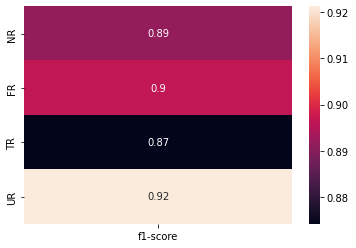

In [ ]:
df_twt15_vis = df_twt15.drop(['accuracy', 'macro avg', 'weighted avg'])
df_twt15_vis = df_twt15_vis.drop(['support', 'precision', 'recall'], axis = 1)
sns.heatmap(df_twt15_vis, annot = True)

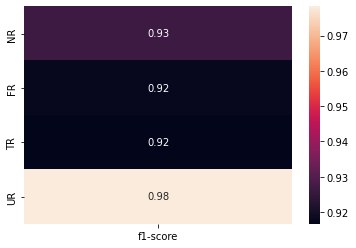

In [ ]:
df_twt16_vis = df_twt16.drop(['accuracy', 'macro avg', 'weighted avg'])
df_twt16_vis = df_twt16_vis.drop(['support', 'precision', 'recall'], axis = 1)
sns.heatmap(df_twt16_vis, annot = True)

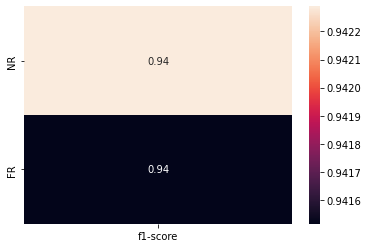

In [ ]:
df_wb_vis = df_wb.drop(['accuracy', 'macro avg', 'weighted avg'])
df_wb_vis = df_wb_vis.drop(['support', 'precision', 'recall'], axis = 1)
sns.heatmap(df_wb_vis, annot = True)